<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395 Redes Neuronales Artificiales 2019-1</h1>

<H3 align='center'> Tarea 1 - Redes Neuronales y *Deep Learning* </H3>
<hr style="height:2px;border:none"/>

## Integrantes

* _**Francisco Olivares - 201473575-8 - fracisco.olivars.14@sansano.usm.cl**_
* _**Gabriel Valenzuela - 201473505-7 - gabriel.valenzuel.14@sansano.usm.cl**_
* _**Felipe Vega - 201473511-1 - felipe.vega.14@sansano.usm.cl**_



<hr style="height:2px;border:none"/>

In [1]:
# Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact 

#Sklearn stuff
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Keras stuff
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD

#Que se vea ancho el jupyter
from IPython.display import IFrame
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))


#Cantidad de columnas a mostrar con pandas
pd.set_option('display.max_columns',100)

Using TensorFlow backend.


>_**a) Explore los datos y visualícelos, ya sea a través de medidas de tendencia o gráficos. Lo primero que deberá realizar será crear su conjunto de validación/test a partir de los datos, por ejemplo las últimas mediciones puesto que la tarea será predecir los datos futuros (out of box). Además escale los datos apropiadamente.**_

In [2]:
# Importando los datos
# df = pd.read_csv("data/ozone_data.csv")

# print("Registros originales:",df.shape[0])

# # Como se quiere predecir el O3 del día siguiente, se crea una nueva columna
# from datetime import datetime, timedelta

# a_day = timedelta(days=1)
# df["is_it_valid"] = False

# old_date = False
# for index, row in df.iterrows():
#     current_date = datetime.strptime(row['registered_on'], "%Y-%m-%d")

#     if old_date:
#         # Se verifica que haya un día de diferencia
#         if old_date == current_date - a_day:
#             # Se cambia el campo is_it_valid
#             df.at[old_index,'is_it_valid'] = True
#             df.at[index,'is_it_valid'] = True
        
#     old_date = current_date
#     old_index = index
    
# df = df[df.is_it_valid == True]
# df.drop(columns=['is_it_valid'])
# display(df.head())
# display(df.describe())

In [101]:
#Import data
df = pd.read_csv("data/ozone_data.csv")
df.head()

,registered_on,CO,PM10,PM25,NO,NOX,WD,RH,TEMP,WS,UVA,UVB,O3
0,2003-12-14,0.172413,0.094241,0.052434,0.016015,0.033293,0.643926,0.670000,0.415679,0.156788,0.035060,0.036334,0.359281
1,2003-12-15,0.241378,0.160995,0.119850,0.084537,0.111707,0.618166,0.822219,0.501561,0.155087,0.034838,0.036579,0.359281
2,2003-12-16,0.344828,0.227749,0.123596,0.118929,0.174259,0.626491,0.504444,0.694880,0.149334,0.033797,0.038170,0.544910
3,2003-12-17,0.275862,0.166230,0.138577,0.103177,0.170368,0.649371,0.503333,0.734857,0.167239,0.027892,0.026847,0.586826
4,2003-12-18,0.344828,0.172775,0.183521,0.119716,0.182938,0.624373,0.654444,0.611180,0.175061,0.032705,0.034957,0.610778


El dataset cuenta con 13 columnas, donde 12 corresponden a la concentración de distintas partículas y la restante muestra la fecha donde se realizó la medición. Los datos medidos tienen un intervalo de 1 día entre ellos. Como el problema a atacar es la predicción de la concentración de $O_3$ en el día siguiente, se procede a graficar este valor en el tiempo para los primeros 50 datos, para así entender como se comporta este valor. 

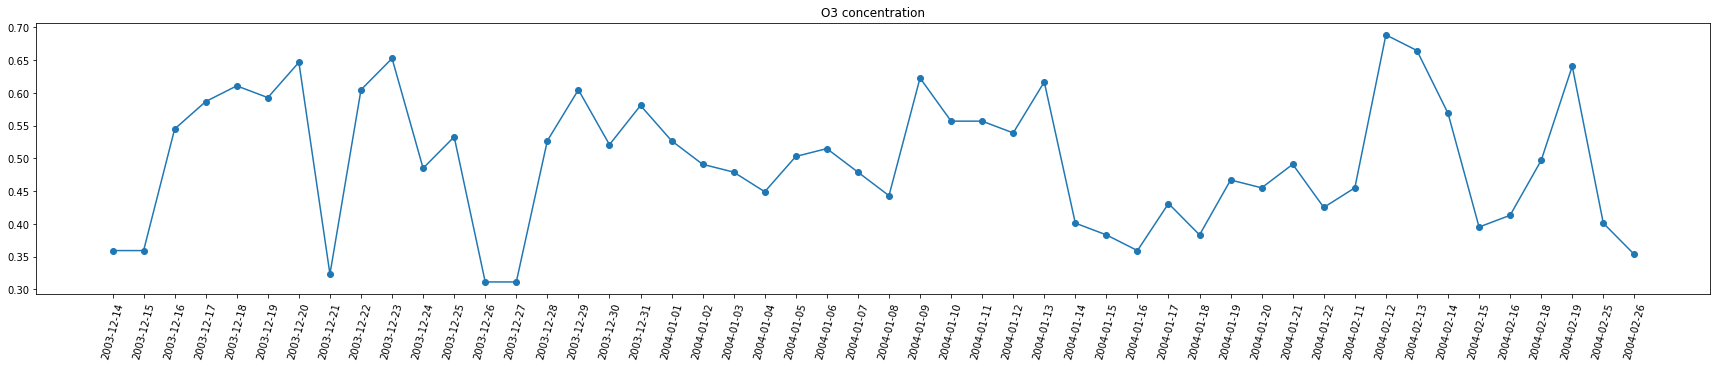

In [102]:
plt.figure(figsize=(30,5))
plt.title("O3 concentration")
plt.plot(df.head(50)['registered_on'],df.head(50)['O3'],'-o')
plt.xticks(rotation=75)
plt.show()

Al observar el gráfico se observa que faltan mediciones, en particular, después del 22 de enero del 2004 viene la medición del 11 de febrero de 2004. Por lo anterior, se prodece a calcular cuanta es la proporción de datos faltantes. Para esto, se agregan los registros de fechas faltantes con NaN.

In [103]:
df.registered_on = pd.to_datetime(df.registered_on, format='%Y-%m-%d')
df.set_index('registered_on',inplace=True)
df = df.resample('D').mean()

In [104]:
"Data faltante  {}%".format(df['O3'].isna().sum()/len(df) * 100)

'Data faltante  65.74132492113564%'

Se observa que la proporción de días que faltan es un 65%, lo cual es bastante elevado. Para continuar con el experimento se probarán distintas maneras se rellenar estos datos faltantes. Antes de comenzar, se genera un resumen para cada columna.

In [105]:
df.describe()

,CO,PM10,PM25,NO,NOX,WD,RH,TEMP,WS,UVA,UVB,O3
count,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000
mean,0.185423,0.129600,0.118716,0.078096,0.143159,0.688165,0.715321,0.552156,0.158919,0.032180,0.033077,0.415092
std,0.084199,0.064871,0.062701,0.062492,0.085842,0.082069,0.140079,0.132291,0.090008,0.031261,0.025226,0.127287
min,0.000000,0.011780,0.003745,0.000147,0.008587,0.000000,0.155555,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.137931,0.094241,0.082397,0.039211,0.091954,0.643123,0.618888,0.482512,0.128617,0.023690,0.028463,0.335329
50%,0.172413,0.117801,0.108614,0.067740,0.130622,0.663091,0.724444,0.569956,0.143259,0.030190,0.034660,0.413174
75%,0.226612,0.148560,0.142322,0.099501,0.169170,0.698589,0.824444,0.636792,0.159043,0.034680,0.037717,0.496634
max,0.700110,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.910180


Se observa que los atributos tienen valores mayores que 0 y menores que 1, donde si se observa el tercer cuartil y el máximo se observa una gran diferencia, lo que indica la posible presencia de outliers en el dataset. Para todos los atributos el valor mínimo es mayor que 0, por lo que rellenar los valores faltantes con 0 no es una buena opción.

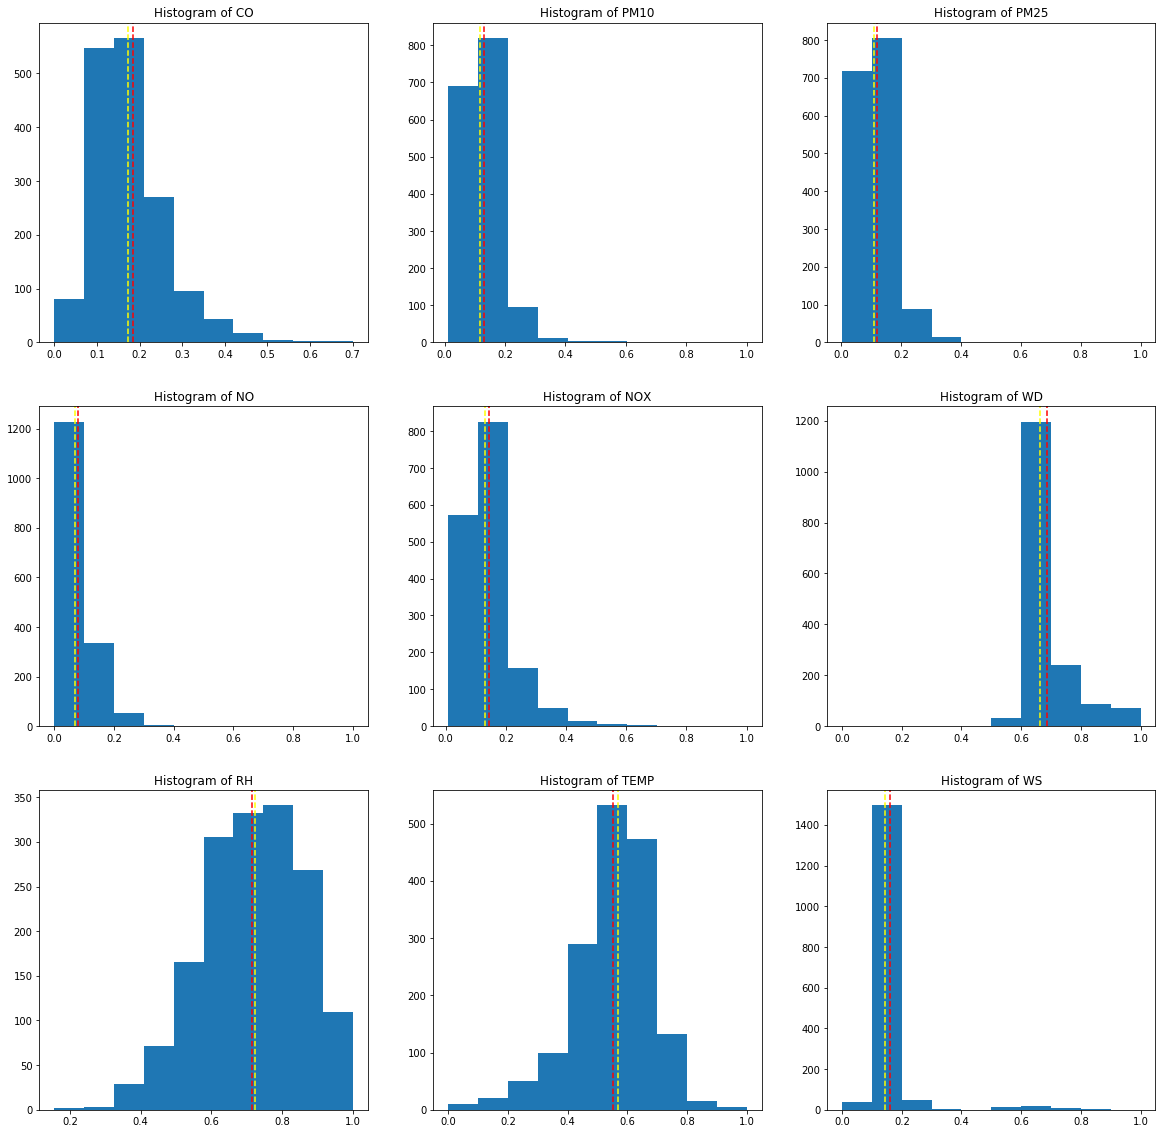

In [106]:
df.head()
plt.figure(figsize=(20,20))
plt.subplot(331)
plt.hist(df.CO)
plt.title("Histogram of CO")
plt.axvline(df['CO'].mean(), color='red', linestyle='dashed', linewidth=1.5)
plt.axvline(df['CO'].median(), color='yellow', linestyle='dashed', linewidth=1.5)
plt.subplot(332)
plt.hist(df.PM10)
plt.title("Histogram of PM10")
plt.axvline(df['PM10'].mean(), color='red', linestyle='dashed', linewidth=1.5)
plt.axvline(df['PM10'].median(), color='yellow', linestyle='dashed', linewidth=1.5)
plt.subplot(333)
plt.hist(df.PM25)
plt.title("Histogram of PM25")
plt.axvline(df['PM25'].mean(), color='red', linestyle='dashed', linewidth=1.5)
plt.axvline(df['PM25'].median(), color='yellow', linestyle='dashed', linewidth=1.5)
plt.subplot(334)
plt.hist(df.NO)
plt.title("Histogram of NO")
plt.axvline(df['NO'].mean(), color='red', linestyle='dashed', linewidth=1.5)
plt.axvline(df['NO'].median(), color='yellow', linestyle='dashed', linewidth=1.5)
plt.subplot(335)
plt.hist(df.NOX)
plt.title("Histogram of NOX")
plt.axvline(df['NOX'].mean(), color='red', linestyle='dashed', linewidth=1.5)
plt.axvline(df['NOX'].median(), color='yellow', linestyle='dashed', linewidth=1.5)
plt.subplot(336)
plt.hist(df.WD)
plt.title("Histogram of WD")
plt.axvline(df['WD'].mean(), color='red', linestyle='dashed', linewidth=1.5)
plt.axvline(df['WD'].median(), color='yellow', linestyle='dashed', linewidth=1.5)
plt.subplot(337)
plt.hist(df.RH)
plt.title("Histogram of RH")
plt.axvline(df['RH'].mean(), color='red', linestyle='dashed', linewidth=1.5)
plt.axvline(df['RH'].median(), color='yellow', linestyle='dashed', linewidth=1.5)
plt.subplot(338)
plt.hist(df.TEMP)
plt.title("Histogram of TEMP")
plt.axvline(df['TEMP'].mean(), color='red', linestyle='dashed', linewidth=1.5)
plt.axvline(df['TEMP'].median(), color='yellow', linestyle='dashed', linewidth=1.5)
plt.subplot(339)
plt.hist(df.WS)
plt.title("Histogram of WS")
plt.axvline(df['WS'].mean(), color='red', linestyle='dashed', linewidth=1.5)
plt.axvline(df['WS'].median(), color='yellow', linestyle='dashed', linewidth=1.5)
plt.show()

Realizando un histograma para cada atributo, marcando también su media (rojo) y su mediana (amarillo) se ve que ambas medidas de tendencia son similares, por lo que no deberían existir muchas diferencias al rellenar con alguno de estos dos valores, prefiriendo la media dado que es más fácil calcularla. Esta será uno de los métodos con los que se rellenarán los datos. Sin embargo, de existir un rango de datos faltantes continuos muy grande se tendrían muchos datos seguidos con un valor constante, lo que podría no ser del todo bueno. Dado lo anterior, también se rellenarán datos faltantes utilizando una interpolación lineal para los datos faltantes considerando sus puntos contiguos.

In [107]:
df_lineal = df.resample('D').interpolate()

In [111]:
df_mean = df.fillna(df.mean())

In [113]:
df_lineal['registered_on'] = df_lineal.index
df_mean['registered_on'] = df_mean.index

A continuación se puede ver un gráfico de la concentración de O3 en el tiempo, considerando un período donde se cuenta con datos faltantes, para así ver las diferencia entre los dos métodos utilizados.

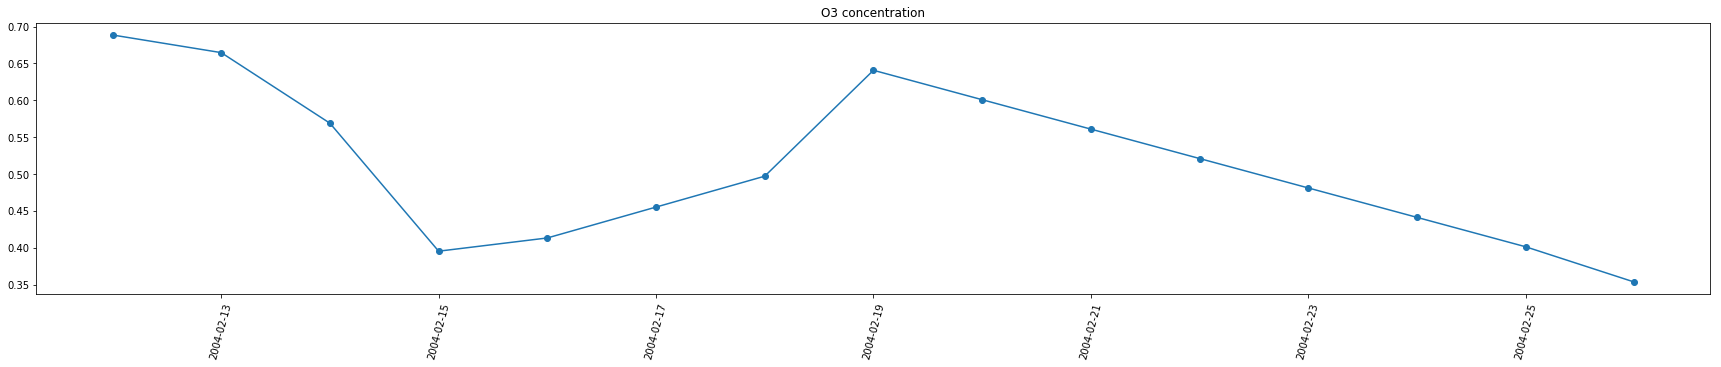

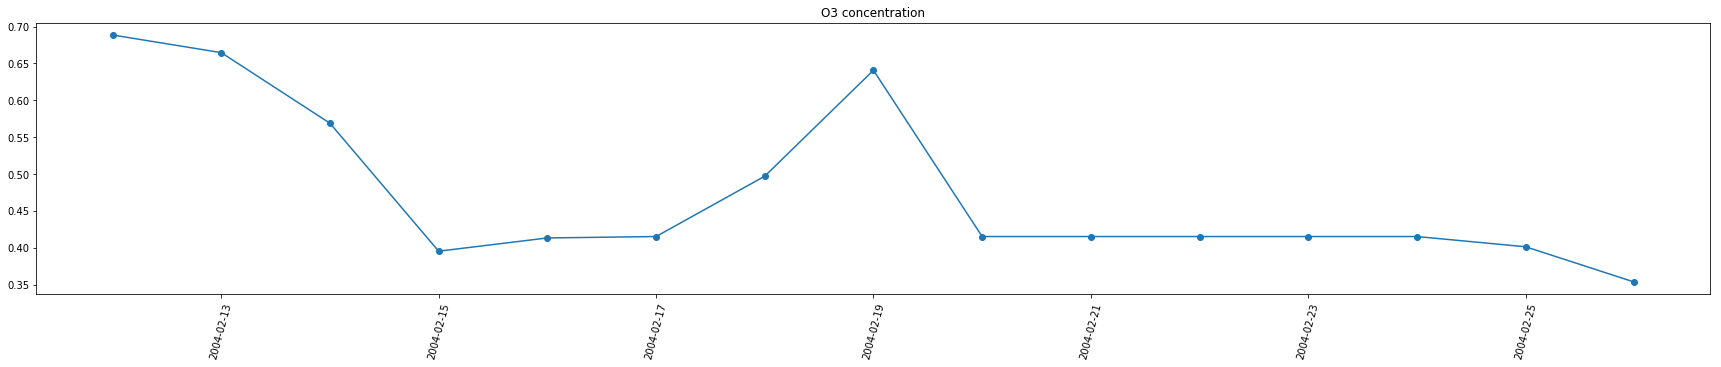

In [116]:
plt.figure(figsize=(30,5))
plt.title("O3 concentration using Lineal Interpolation to fill missing values")
plt.plot(df_lineal['registered_on'][60:75],df_lineal['O3'][60:75],'-o')
plt.xticks(rotation=75)
plt.show()

plt.figure(figsize=(30,5))
plt.title("O3 concentration using Mean to fill missing values")
plt.plot(df_mean['registered_on'][60:75],df_mean['O3'][60:75],'-o')
plt.xticks(rotation=75)
plt.show()

In [122]:
"Data lenght: {}".format(len(df_lineal))

'Data lenght: 4755'

Una vez rellenados los valores faltantes es necesario separar nuestro conjunto de datos en entrenamiento, validación y testing. Se cuenta con 4755 registros, de los cuales se realizará una separación 80 y 20 entre entrenamiento y testing, y sacando un 20% para validación desde el conjunto de entrenamiento. Como nos encontramos analizando series de tiempo, no podemos tomar registros al azar para obtener los 3 conjuntos, por lo que se tomarán secuencialmente.

In [138]:
df_lineal_train = df_lineal[0:3084]
df_lineal_test = df_lineal[3084:4755]
df_mean_train = df_mean[0:3084]
df_mean_test = df_mean[3084:4755]

In [139]:
df_lineal_train = df_lineal_train[0:2467]
df_lineal_val = df_lineal_train[2467:3084]
df_mean_train = df_mean_train[0:2467]
df_mean_val = df_mean_train[2467:3084]

Así cada conjunto queda con la siguiente cantidad de registros.

In [146]:
print()"Data lenght in train set: {}".format(len(df_lineal_train))
"Data lenght in validation set: {}".format(len(df_lineal_val))
"Data lenght in test set: {}".format(len(df_lineal_test))

'Data lenght in test set: 1671'


<hr style="height:2px;border:none"/>